## Tensile testing



In [ ]:
# load some common packages
import matplotlib.pyplot as plt
# define parameter object (value + unit), used later to define soil, root and geometry objects
from collections import namedtuple
Parameter = namedtuple("parameter", "value unit")

### Load data

(array([1., 0., 1., 0., 0., 1., 0., 1., 0., 1.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

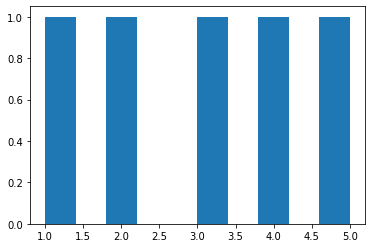

In [ ]:
# load tensile strength data from csv
from pyrootmemo.io import read_csv_roots
roots_tensile = read_csv_roots('test_tensile_data.csv')
# plot histogram of root diameters in tensile strength data
plt.hist(roots_tensile.diameter)

### Biomechanics: power law fitting

#### Tensile strength

Multiplier: 10.325005341660777 megapascal
Exponent: -0.2794621276741685


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Diameter [mm]', ylabel='Tensile strength [MPa]'>)

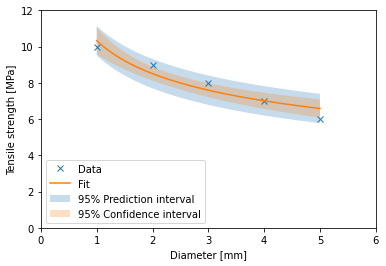

In [ ]:
# load various fitting functions
from pyrootmemo.fit.fit_xy_powerlaw import PowerlawFit
# define fit type
fit_model = 'normal'
# generate tensile strength fit
fit_tensile_strength = PowerlawFit(roots_tensile.diameter, roots_tensile.tensile_strength, model = fit_model)
# show results
print('Multiplier:', fit_tensile_strength.multiplier)
print('Exponent:', fit_tensile_strength.exponent)
fit_tensile_strength.plot(prediction = True)

#### Young's modulus

Multiplier: 203.25198556942078 megapascal
Exponent: -0.12971366534799691


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Diameter [mm]', ylabel='Tensile strength [MPa]'>)

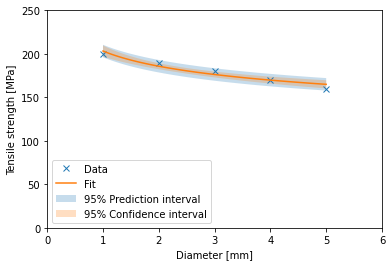

In [ ]:
# generate fit
fit_elastic_modulus = PowerlawFit(roots_tensile.diameter, roots_tensile.elastic_modulus, model = fit_model)
# show results
print('Multiplier:', fit_elastic_modulus.multiplier)
print('Exponent:', fit_elastic_modulus.exponent)
fit_elastic_modulus.plot(prediction = True)

#### Root length

Multiplier: 517.5841169492132 millimeter
Exponent: -0.07977109368017368


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Diameter [mm]', ylabel='Tensile strength [mm]'>)

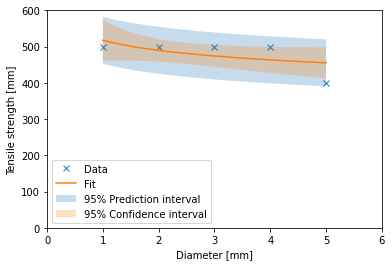

In [ ]:
# generate fit
fit_length = PowerlawFit(roots_tensile.diameter, roots_tensile.length, model = fit_model)
# show results
print('Multiplier:', fit_length.multiplier)
print('Exponent:', fit_length.exponent)
fit_length.plot(prediction = True, yunit = 'mm')

## Reinforcement predictions

#### Data

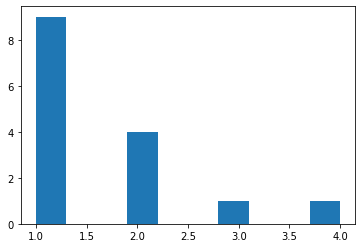

In [6]:
# load data
roots_field = read_csv_roots('test_field_data.csv')
# plot histogram of diameter
plt.hist(roots_field.diameter)
# make predictions for root properties using fitted power laws
roots_field.tensile_strength = fit_tensile_strength.predict(roots_field.diameter)
roots_field.elastic_modulus = fit_elastic_modulus.predict(roots_field.diameter)
roots_field.length = fit_length.predict(roots_field.diameter)

In [7]:
# define soils
from pyrootmemo.materials import Soil
soil = Soil(
    'test',
    cohesion = Parameter(2.0, 'kPa'),
    friction_angle = Parameter(30, 'deg')
    )
# define soil profile
from pyrootmemo.geometry import SoilProfile
soil_profile = SoilProfile(
    [soil],
    depth = Parameter([100], 'm')
    )

In [8]:
# define a failure surface
from pyrootmemo.geometry import FailureSurface
failure_surface = FailureSurface(
    depth = Parameter(1.0, 'm'),
    cross_sectional_area = Parameter(1.0, 'm^2'),
    shear_zone_thickness = Parameter(5.0, 'mm')
    )

#### Wu/Waldron Model

In [9]:
from pyrootmemo.wwm import Wwm
wwm = Wwm(roots_field)
reinforcement = wwm.peak_reinforcement(
    failure_surface,
    k = 1.2
    )
print(reinforcement.to('kPa'))

0.3859740764050246 kilopascal


#### Fibre bundle models

282.60167161142107 newton
0.2826016716114211 kilopascal


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Force in reference root [N]', ylabel='Total force in root bundle [N]'>)

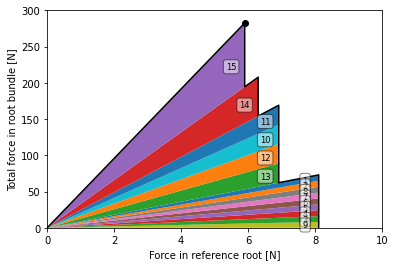

In [18]:
from pyrootmemo.fbm import Fbm
# define load sharing factor
load_sharing = 2.0 + fit_elastic_modulus.exponent - fit_length.exponent
# generate FBM object
fbm = Fbm(roots_field, load_sharing)
# calculate peak force and reinforcement
print(fbm.peak_force().to('N'))
print(fbm.peak_reinforcement(failure_surface, k = 1.0).to('kPa'))
# show mobilisation of forces
fbm.plot(peak = True, stack = True, labels = True)

#### RBMw

0.23068053480133624 kilopascal


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Displacement [mm]', ylabel='Total force in root bundle [N]'>)

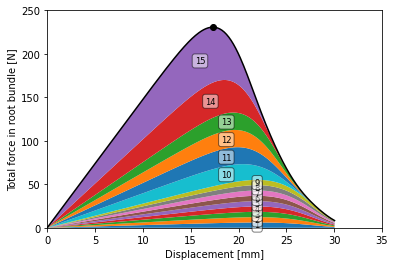

In [19]:
from pyrootmemo.rbmw import Rbmw
# define the Weibull shape factor
weibull_shape = 10.0
# generate RBMw object
rbmw = Rbmw(roots_field, weibull_shape)
# calculate peak reinforcement
print(rbmw.peak_reinforcement(failure_surface, k = 1.0).to('kPa'))
# plot how reinforcement mobilises with pullout displacement
rbmw.plot(stack = True, labels = True)